In [0]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imsave, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, BatchNormalization, Conv2DTranspose, Add, Cropping2D, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
print(tf.__version__)
#should be running on tensorflow 1.15
import re

from google.colab import drive

1.15.0


Using TensorFlow backend.


In [0]:
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = '/content/drive/My Drive/Assignment 3/training_validation_Hair_Skin_Masks/training_hair_skin/images/'
TEST_PATH = '/content/drive/My Drive/Assignment 3/testing_images/testing_images/'
MASK_PATH = '/content/drive/My Drive/Assignment 3/training_validation_Hair_Skin_Masks/training_hair_skin/masks/'
VALID_PATH = '/content/drive/My Drive/Assignment 3/training_validation_Hair_Skin_Masks/validation_hair_skin/images/'
VALID_MASK = '/content/drive/My Drive/Assignment 3/training_validation_Hair_Skin_Masks/validation_hair_skin/masks/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [0]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[2]
train_mask = next(os.walk(MASK_PATH))[2]
valid_ids = next(os.walk(VALID_PATH))[2]
valid_mask = next(os.walk(VALID_MASK))[2]
test_ids = next(os.walk(TEST_PATH))[2]

print(len(train_ids))
print(len(train_mask))
print(len(valid_ids))
print(len(valid_mask))
print(len(test_ids))

1500
1500
500
500
927


In [0]:
# Get and resize train and validation images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
X_validation = np.zeros((len(valid_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8) 
Y_validation = np.zeros((len(valid_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
  path = TRAIN_PATH + id_
  path2 = TRAIN_PATH + id_
  path2 = path2.replace(TRAIN_PATH+'train_img_',MASK_PATH+ 'train_mask_')
  path2 = path2.replace('jpg','ppm')

  img = imread(path)[:,:,:IMG_CHANNELS]
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_train[n] = img
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
  mask_ = imread(path2)
  mask_ = resize(mask_,(IMG_HEIGHT,IMG_WIDTH), mode='constant', preserve_range=True)
  mask = np.maximum(mask,mask_)
  Y_train[n] = mask

print('Getting and resizing validation images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(valid_ids), total=len(valid_ids)):
  path = VALID_PATH + id_
  path2 = VALID_PATH + id_
  path2 = path2.replace(VALID_PATH+'validation_img_',VALID_MASK+ 'validation_mask_')
  path2 = path2.replace('jpg','ppm')
  img = imread(path)[:,:,:IMG_CHANNELS]
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_validation[n] = img
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
  mask_ = imread(path2)
  mask_ = resize(mask_,(IMG_HEIGHT,IMG_WIDTH), mode='constant', preserve_range=True)
  mask = np.maximum(mask,mask_)
  Y_validation[n] = mask


# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Finished!')

Getting and resizing train images and masks ... 


100%|██████████| 1500/1500 [23:53<00:00,  1.04it/s]

Getting and resizing validation images and masks ... 



100%|██████████| 500/500 [07:48<00:00,  1.22it/s]

Getting and resizing test images ... 



100%|██████████| 927/927 [08:24<00:00,  1.96it/s]

Finished!


In [0]:
Y_train_new = Y_train.argmax(axis=3)
Y_train_new = np.expand_dims(Y_train_new, 3)

In [0]:
Y_validation_new = Y_validation.argmax(axis=3)
Y_validation_new = np.expand_dims(Y_validation_new, 3)

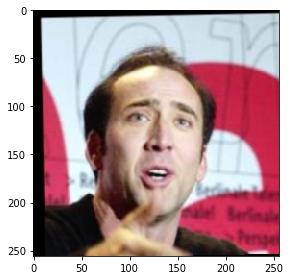

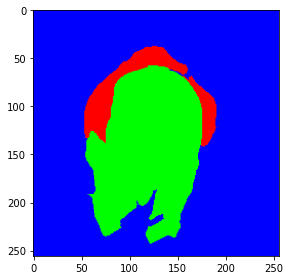

In [0]:
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [0]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

#LOSS_FUNCTION
smooth = 1.0
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_coef_loss(y_true, y_pred):
  return tf.keras.metrics.binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)


def softmax_sparse_crossentropy_ignoring_last_label(y_true, y_pred):
    y_pred = K.reshape(y_pred, (-1, K.int_shape(y_pred)[-1]))
    log_softmax = tf.nn.log_softmax(y_pred)

    y_true = K.one_hot(tf.to_int32(K.flatten(y_true)), K.int_shape(y_pred)[-1]+1)
    unpacked = tf.unstack(y_true, axis=-1)
    y_true = tf.stack(unpacked[:-1], axis=-1)

    cross_entropy = -K.sum(y_true * log_softmax, axis=1)
    cross_entropy_mean = K.mean(cross_entropy)

    return cross_entropy_mean

In [0]:
def FCN8(pretrained=False, input_shape=(224, 224, 3), num_classes = 1,learning_rate=1e-4):
  if num_classes == 1:
    loss_fn = 'binary_crossentropy'
    activation = 'sigmoid'
  else:
    loss_fn = 'sparse_categorical_crossentropy'
    activation = 'softmax'

  if pretrained:
    base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
    base_input = base_model.input
    base_output = base_model.output

    pool4 = base_model.get_layer('block4_pool').output
    pool3 = base_model.get_layer('block3_pool').output

    conv6 = Conv2D(2048 , (7, 7) , activation='elu' , padding='same', name="conv6")(base_output)
    conv6 = Dropout(0.5)(conv6)
    conv7 = Conv2D(2048 , (1, 1) , activation='elu' , padding='same', name="conv7")(conv6)
    conv7 = Dropout(0.5)(conv7)
    conv7 = Conv2D(num_classes, (1,1), activation='elu', padding='valid', name='conv7_bottleneck')(conv7)

    u2 = Conv2DTranspose(num_classes, kernel_size=(4, 4), strides=(2, 2), padding='valid', name='u2')(conv7)
    c2 = Cropping2D(((0,2),(0,2)))(u2)
    pool4_n = Conv2D(num_classes, kernel_size=(1, 1), activation='elu', padding='same', name='pool4_n')(pool4)
    u2_skip = Add()([c2, pool4_n])

    u4 = Conv2DTranspose(num_classes, kernel_size=(4, 4), strides=(2, 2), padding='valid', name='u4')(u2_skip)
    c4 = Cropping2D(((0,2), (0,2)))(u4)
    pool3_n = Conv2D(num_classes, (1, 1), activation='elu', padding='same', name='pool3_n')(pool3)
    u4_skip = Add()([c4, pool3_n])

    output = Conv2DTranspose(num_classes, kernel_size=(16, 16), strides=(8, 8), padding='valid', activation=activation)(u4_skip)
    output = Cropping2D(((0,8),(0,8)))(output)

    model = Model(inputs=[base_input], outputs=[output])
    model.compile(optimizer=Adam(learning_rate), loss=loss_fn, metrics=['sparse_categorical_accuracy'])

    return model
  else:
    b = 6

    input = Input(shape=input_shape)
    s = Lambda(lambda x: x / 255) (input)

    ## Block 1
    x = Conv2D(2**b, (3, 3), activation='elu', padding='same', name='block1_conv1')(s)
    x = Conv2D(2**b, (3, 3), activation='elu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    f1 = x

    # Block 2
    x = Conv2D(2**(b+1), (3, 3), activation='elu', padding='same', name='block2_conv1')(x)
    x = Conv2D(2**(b+1), (3, 3), activation='elu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    f2 = x

    # Block 3
    x = Conv2D(2**(b+2), (3, 3), activation='elu', padding='same', name='block3_conv1')(x)
    x = Conv2D(2**(b+2), (3, 3), activation='elu', padding='same', name='block3_conv2')(x)
    x = Conv2D(2**(b+2), (3, 3), activation='elu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    pool3 = x

    # Block 4
    x = Conv2D(2**(b+3), (3, 3), activation='elu', padding='same', name='block4_conv1')(x)
    x = Conv2D(2**(b+3), (3, 3), activation='elu', padding='same', name='block4_conv2')(x)
    x = Conv2D(2**(b+3), (3, 3), activation='elu', padding='same', name='block4_conv3')(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(2**(b+3), (3, 3), activation='elu', padding='same', name='block5_conv1')(pool4)
    x = Conv2D(2**(b+3), (3, 3), activation='elu', padding='same', name='block5_conv2')(x)
    x = Conv2D(2**(b+3), (3, 3), activation='elu', padding='same', name='block5_conv3')(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    conv6 = Conv2D(2048 , (7, 7) , activation='elu' , padding='same', name="conv6")(pool5)
    conv6 = Dropout(0.5)(conv6)
    conv7 = Conv2D(2048 , (1, 1) , activation='elu' , padding='same', name="conv7")(conv6)
    conv7 = Dropout(0.5)(conv7)

    conv7 = Conv2D(num_classes, (1,1), activation='elu', padding='valid', name='conv7_bottleneck')(conv7)

    u2 = Conv2DTranspose(num_classes, kernel_size=(4,4), strides=(2,2), padding='valid', name='u2')(conv7)
    c2 = Cropping2D(((0,2),(0,2)))(u2)
    pool4_n = Conv2D(num_classes, kernel_size=(1, 1), activation='elu', padding='same', name='pool4_n')(pool4)
    u2_skip = Add()([c2, pool4_n])

    u4 = Conv2DTranspose(num_classes, kernel_size=(4, 4), strides=(2, 2), padding='valid')(u2_skip)
    c4 = Cropping2D(((0,2), (0,2)))(u4)
    pool3_n = Conv2D(num_classes, kernel_size=(1, 1), activation='elu', padding='same', name='pool3_n')(pool3)
    u4_skip = Add()([c4, pool3_n])

    output = Conv2DTranspose(num_classes, kernel_size=(16, 16), strides=(8, 8), padding='valid', activation=activation)(u4_skip)
    output = Cropping2D(((0,8),(0,8)))(output)
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=Adam(learning_rate), loss=loss_fn, metrics=['sparse_categorical_accuracy'])
    return model

In [0]:
 model = FCN8(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), num_classes=3, pretrained=False, learning_rate=1e-3)
 model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        lambda_2[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
____________________________________________________________________________________________

In [0]:
earlystopper = EarlyStopping(patience=100, verbose=1)
checkpointer = ModelCheckpoint('/content/' +'fourthModel.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train_new, validation_data= (X_validation,Y_validation_new), batch_size=64, epochs=100, callbacks=[earlystopper, checkpointer])

Train on 1500 samples, validate on 500 samples
Epoch 1/100


ResourceExhaustedError: ignored

In [0]:
# Predict on train, val and test
model = load_model('/content/fourthModel.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)
# Threshold predictions accounting for multiple channels (hair segmentation)
preds_train_t = (preds_train.argmax(axis=3) == 0).astype(np.uint8)
preds_val_t = (preds_val.argmax(axis=3) == 0).astype(np.uint8)
preds_test_t = (preds_test.argmax(axis=3) == 0).astype(np.uint8)
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i,:,:,0]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
927/927 [==============================] - 52s 56ms/sample


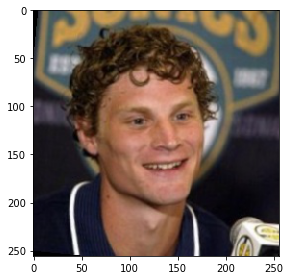

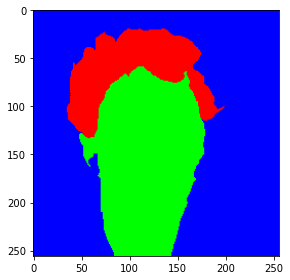

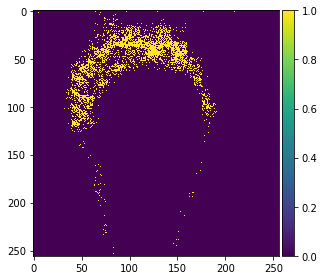

In [0]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [0]:
from skimage.io import imsave
TESTMASK_PATH = '/content/drive/My Drive/Assignment 3/testing_masks/'
def savemask(pred):
  for i in range(len(pred)):
    files = test_ids[i].replace('img','mask')
    imsave(os.path.join(TESTMASK_PATH,files),pred[i])
savemask(preds_test_upsampled)

def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths
    print(len(os.listdir(input_path)))


In [0]:
# (* update) the input_path using your folder path
input_path = '/content/drive/My Drive/Assignment 3/testing_masks/'

# get a sorted list of all mask filenames in the folder
masks = [f for f in os.listdir(input_path) if f.endswith('.jpg')]
masks = sorted(masks, key=lambda s:int(s.split('_')[2].split('.')[0]))

# encode all masks
encodings = []
for file in masks:
    mask = imread('/content/drive/My Drive/Assignment 3/testing_masks/'+file)
    #img_size = 250
    #mask = resize(mask, (img_size, img_size), mode='constant', preserve_range=True)
    mask = np.array(mask, dtype=np.uint8)
    mask = np.round(mask/255)
    encodings.append(rle_encoding(mask))


# (** update) the path where to save the submission csv file
sub = pd.DataFrame()
sub['ImageId'] = pd.Series(masks).apply(lambda x: os.path.splitext(x)[0])
sub['EncodedPixels'] = pd.Series(encodings).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv(os.path.join("/content/drive/My Drive/predictionsBruh.csv"), index=False)